In [1]:
import numpy as np
from PIL import Image
import scipy.io.wavfile
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

import pca

# Applications

## Compress images

In [2]:
def show_img(im, title=None, ax=None):
    ax = ax or plt.gca()
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

Image size: (1494, 1038)
Preview:


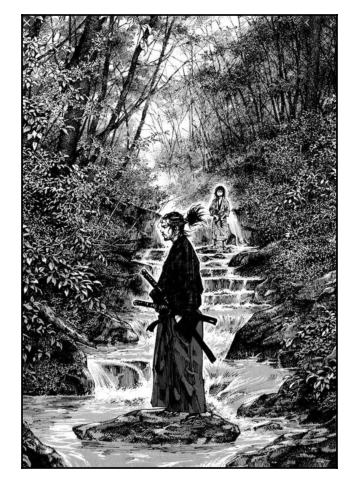

In [3]:
# Load image
im = Image.open('input/images/sample.jpg').convert('L')
im_arr = np.array(im)
print('Image size:', im_arr.shape)

# Preview
print('Preview:')
show_img(im_arr)
plt.show()

In [4]:
h, w = im_arr.shape

ks = np.arange(0, 1001, 10)[1:]
imks = np.zeros(shape=(len(ks), h, w))

for i, k in enumerate(ks):
    Uk, x_mean, Z = pca.compress(im_arr, k)
    im_compressed = pca.decode(Uk, x_mean, Z)
    imks[i] = im_compressed

In [5]:
output_dir = 'output/images/sample/imgs'
for k, im in zip(ks, imks):
    Image.fromarray(im).convert('L').save(output_dir + '/' + f'I{k:04d}.jpg')

A keen observer will notice that this is almost the same as SVD, differing only by the storing of mean vector with size $w$ instead of the values on the diagonal of $S$, which is of size $k$. Because $k \leq w$, SVD is better in terms of the compression rate with the same $k$.

In [6]:
errorks = np.zeros(len(ks))
rks = np.zeros(len(ks))

for i, k in enumerate(ks):
    ori_size = h * w
    cpr_size = 4 * (h * k + w + k * w)
    rks[i] = cpr_size / ori_size

In [7]:
f = open('output/images/sample/rk.txt', 'w')
for k, rk in zip(ks, rks):
    f.write(f'k = {k:4d}: {rk:.9f}\n')
f.close()

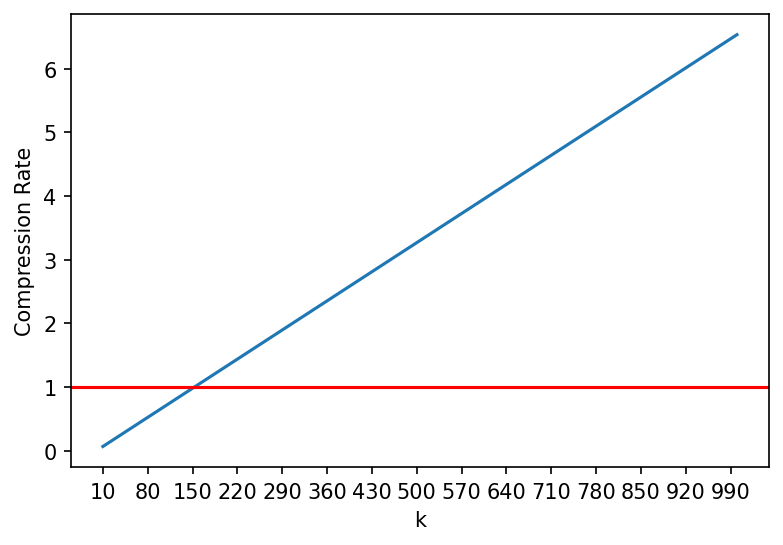

In [8]:
plt.plot(ks, rks)
plt.xticks(ks[np.arange(0, len(ks), 7)])

plt.axhline(1, 0, 1, color='r')

plt.xlabel('k')
plt.ylabel('Compression Rate')

plt.savefig('output/images/sample/compression-rate')

## Compress audio files

In [9]:
def pad(x, sz):
    if len(x) % sz == 0:
        return x
    pad = sz - len(x) % sz
    x_padded = np.zeros(len(x) + pad).astype(x.dtype)
    x_padded[:len(x)] = x
    return x_padded

In [10]:
sr, arr = scipy.io.wavfile.read('input/audios/sample.wav')
print(arr.shape)
arr = arr[:, 0]

(1043881, 2)
<ipython-input-10-d9aff6469619>:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, arr = scipy.io.wavfile.read('input/audios/sample.wav')


In [11]:
au_arr_padded = pad(arr, 1024)
au_arr = au_arr_padded.reshape((-1, 1024))

In [12]:
output_dir = 'output/audios/sample/wavs'

h, w = au_arr.shape

ks = np.arange(0, 1001, 10)[1:]
audioks = np.zeros(shape=(len(ks), len(arr))).astype(np.int16)

for i, k in enumerate(ks):
    Uk, x_mean, Z = pca.compress(au_arr, k)
    au_compressed = pca.decode(Uk, x_mean, Z)

    audioks[i] = au_compressed.reshape(-1)[:len(arr)].astype(np.int16)

In [13]:
output_dir = 'output/audios/sample/wavs'
for k, audio in zip(ks, audioks):
    scipy.io.wavfile.write(output_dir + '/' + f'W{k:04d}.wav', sr, audio)

For the computation of the compression ratio:
- The original file is stored as a 16-bit 1D array, so it takes $2 \times l$ (bytes) where $l$ is the length of the array.
- The PCA method compresses by first padding $l$ to be divisible by $b$ then reshaping it to $h, w$ with $h = \lfloor l / b \rfloor + 1(l > 0 \mod b)$ and $w = b$. Finally, it is stored as the $U_k$ matrix of size $w \times k$, the mean vector of size $w$ (for decoding), and the compressed $Z$ of size $h \times k$. Each of this is a 4-byte floating point array. Therefore, the compressed size is $4 \times (h \times k + w + w \times k)$.

The compression rate is therefore:
$$
    2 \times \frac{h \times k + w + w \times k}{l}
$$
where $h = \lfloor l / b \rfloor + 1(l > 0 \mod b)$ and $w = b$.

In [14]:
l = len(arr)

N, M = 2500, 1024
r = np.zeros((N, M))
for b in range(1, N):
    for k in range(1, M):
        ori_sz = 2 * l
        h, w = (l // b + (l % b > 0)), b
        cpr_sz =  4 * (h * k + w + w * k)
        r[b, k] = cpr_sz / ori_sz

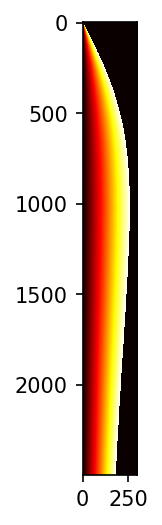

In [15]:
r_ = r.copy()
r_[r >= 1] = 0
r_ = r_[:, :300]
plt.imshow(r_, cmap='hot', interpolation='nearest')
plt.show()

For a fixed $b$, the compression rate is linear with respect to $k$.

For a fixed $k$, we can approximate $h = l / b$. Then, the compression rate is 
$$
    r(b, k) = 2 \times \left[ k \times \frac{1}{b} + \frac{1+k}{l} \times b \right]
$$
which is convex with respect to $b$. 

The lowest compression rate is when
$$
    \hat{b} \approx \sqrt{\frac{l \times k}{k + 1}}
$$
and has the value of
$$
    r(\hat{b}, k) = 4 \times \sqrt{\frac{k(k+1)}{l}}
$$

We need $k$ such that $\exists b, r(b, k) < 1$. This means that $r(\hat{b}, k) < 1$
$$
    k < \sqrt{\frac{l}{16} + \frac{1}{4}} - \frac{1}{2}
$$

In [16]:
b = 1024
f = open('output/audios/sample/rk.txt', 'w')

for k in ks:
    f.write(f'k = {k:4d}: {r[b, k]:.9f}\n')
f.close()

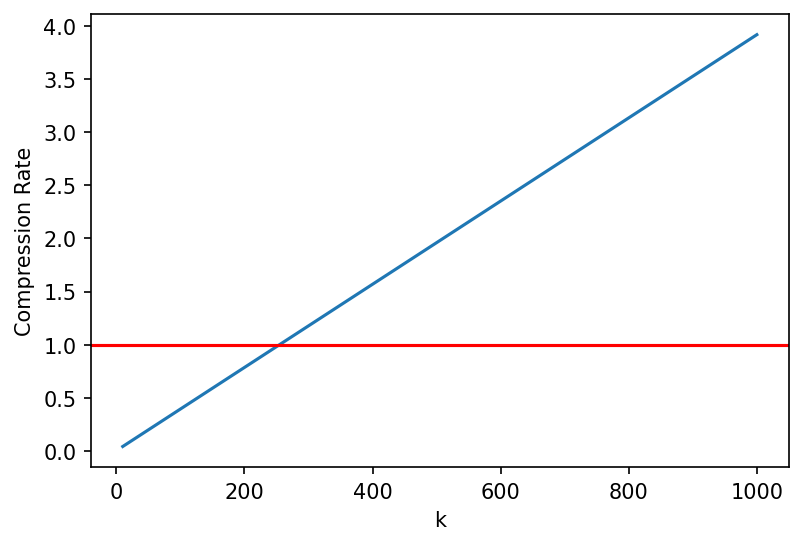

In [17]:
plt.plot(ks, r[b, ks])

plt.axhline(1, 0, 1, color='r')

plt.xlabel('k')
plt.ylabel('Compression Rate')

plt.savefig('output/audios/sample/compression-rate')